# Nino box example

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
import pyresample

In [2]:
%matplotlib inline

In [3]:
opendap_data_url = 'http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Omon/tos/gn/v20181212/tos_Omon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc'

## Load data from the opendap server into a dataarray

In [4]:
ds = xr.open_dataset(opendap_data_url)

xarray have built-in functions and cartopy integration but they are limited, definitely not publication-type plots

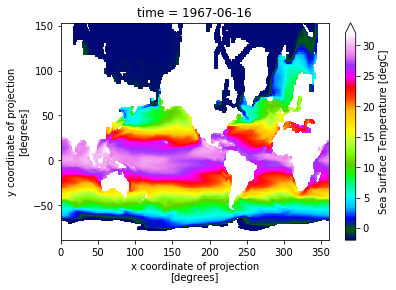

In [5]:
ds.sel(time='1967-06')['tos'].plot(vmin=-2, vmax=32, cmap='gist_ncar')

For that, we want to extract the data and farm it off to cartopy. Cartopy doesn't like the discontinuity in longitude
so we're gonna remap onto a regular grid.

### Plotting functions

In [6]:
def plot_robinson(lon, lat, data, dict_plt):
    plt.figure(figsize=[15, 10])
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    C = plt.contourf(lon, lat, data, np.arange(dict_plt['vmin'], dict_plt['vmax'], dict_plt['cstep']),
                     cmap=dict_plt['cmap'],
                     transform=ccrs.PlateCarree())
    plt.colorbar(C, shrink=0.6)
    ax.coastlines()
    ax.stock_img()
    
    # add the nino3.4 box
    plt.plot(-170 * np.ones(11), np.arange(-5,5+1),'k--', transform=ccrs.PlateCarree())
    plt.plot(-120 * np.ones(11), np.arange(-5,5+1),'k--', transform=ccrs.PlateCarree())
    plt.plot(np.arange(-170,-120+5,5), 5 * np.ones(11),'k--', transform=ccrs.PlateCarree())
    plt.plot(np.arange(-170,-120+5,5), -5 * np.ones(11),'k--', transform=ccrs.PlateCarree())

def resample(dataarray, hres=1):
    ''' resample the tripolar grid onto a regular grid for plotting purpose only'''
    # input grid
    lons_in = dataarray['longitude'].values.ravel()
    lons_in[np.where(lons_in > 180)] -= 360
    lats_in = dataarray['latitude'].values.ravel()

    grid_src = pyresample.geometry.SwathDefinition(lons=lons_in, lats=lats_in)

    # output grid
    lon = np.arange(-180, 180, hres) + hres/2
    lat = np.arange(-90, 90, hres) + hres/2
    lon_out, lat_out = np.meshgrid(lon, lat)

    grid_target = pyresample.geometry.GridDefinition(lons=lon_out,
                                                      lats=lat_out)

    data = pyresample.kd_tree.resample_nearest(grid_src, dataarray.values,
                                                grid_target,
                                                radius_of_influence=100000,
                                                fill_value=0)
    return lon, lat, data

## SST plot for June 1967

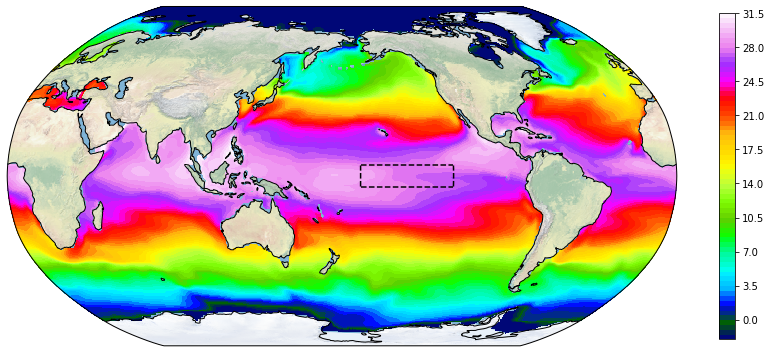

In [7]:
lon, lat, data = resample(ds.sel(time='1967-06')['tos'].squeeze('time'), hres=1)
dict_plt= {'vmin': -2, 'vmax': 32, 'cstep': 0.5, 'cmap': cm.gist_ncar}
plot_robinson(lon, lat, data, dict_plt)

### Functions for spatial averaging with xarray

In [8]:
def compute_area(dataset):
    ''' compute cell area.
    close to the equator the grid is mercator type so we don't need to
    correct for grid cell distortion
    '''
    Rearth = 6400000.
    dx = Rearth * np.cos( 0.5 * (dataset['vertices_latitude'].isel(vertices=1) +
                                 dataset['vertices_latitude'].isel(vertices=2))) * \
                  (dataset['vertices_longitude'].isel(vertices=1) -
                   dataset['vertices_longitude'].isel(vertices=0) )
    
    dy = Rearth * (dataset['vertices_latitude'].isel(vertices=2) -
                   dataset['vertices_latitude'].isel(vertices=1) )
    
    dataset['area'] = dx * dy 
    return dataset

In [9]:
def avg2d(dataarray, cell_area):
    ''' compute horizontal spatial average'''
    out = (dataarray * cell_area).sum(dim=['x','y']) / \
    (cell_area).where(dataarray.fillna(-9999) != -9999).sum(dim=['x','y'])
    return out

## Compute the climatology in the nino3.4 box

### monthly climatology

In [10]:
# extract the area of interest, would be more elegant if longitude/latitude where dimensions but that requires them to be 1d
nino34_box = ds['tos'].where(ds['longitude'] >= 360-170).where(ds['longitude'] <= 360-120).where(ds['latitude'] >= -5).where(ds['latitude'] <= 5)
# compute the monthly climatology
clim_nino34_box = nino34_box.groupby(nino34_box.time.dt.month).mean(dim='time')

/opt/anaconda3/5.1.0/envs/gfdl/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### compute the spatial average

In [11]:
# compute cell area and append to dataset ds
ds = compute_area(ds)

In [12]:
# compute spatial average over nino3.4 box
clim_nino34_box_timeserie = avg2d(clim_nino34_box, ds['area'])

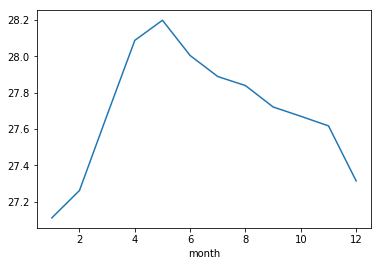

In [13]:
# plot the climatology
clim_nino34_box_timeserie.plot()

## Compute the anomaly

In [14]:
# we can get the anomaly very easily thanks to groupby
anomaly_nino34box = nino34_box.groupby(nino34_box.time.dt.month) - clim_nino34_box

In [15]:
# spatial average of the anomaly over nino3.4 box
anomaly_nino34box_timeserie = avg2d(anomaly_nino34box, ds['area'])

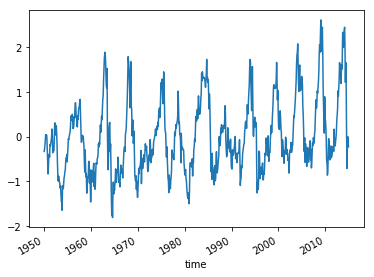

In [16]:
# plot the anomaly
anomaly_nino34box_timeserie.plot()